In [7]:
# Numerical libraries
import numpy as np
import pandas as pd

# Data download
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt

# Statistical tools
from scipy.stats import norm

# Settings
plt.style.use('seaborn-v0_8')
%matplotlib inline


In [8]:
ticker = "^FCHI"
data = yf.download(ticker, start="2010-01-01", end="2024-12-31")

# Flatten MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(data.columns)

# Use Close price
data = data[['Close']]
data.rename(columns={'Close': 'price'}, inplace=True)

data.head()



[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,price
Date,
2010-01-04,4013.969971
2010-01-05,4012.909912
2010-01-06,4017.669922
2010-01-07,4024.800049
2010-01-08,4045.139893


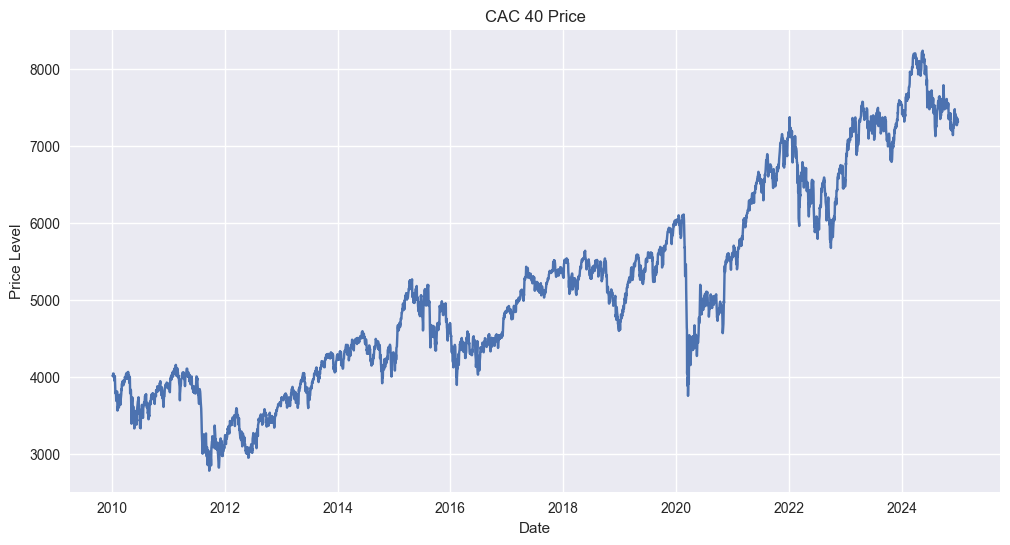

In [9]:

plt.figure(figsize=(12,6))
plt.plot(data['price'])
plt.title("CAC 40 Price")
plt.xlabel("Date")
plt.ylabel("Price Level")
plt.show()


In [10]:
data['log_return'] = np.log(data['price'] / data['price'].shift(1))
data = data.dropna()

data.head()


Price,price,log_return
Date,,
2010-01-05,4012.909912,-0.000264
2010-01-06,4017.669922,0.001185
2010-01-07,4024.800049,0.001773
2010-01-08,4045.139893,0.005041
2010-01-11,4043.090088,-0.000507


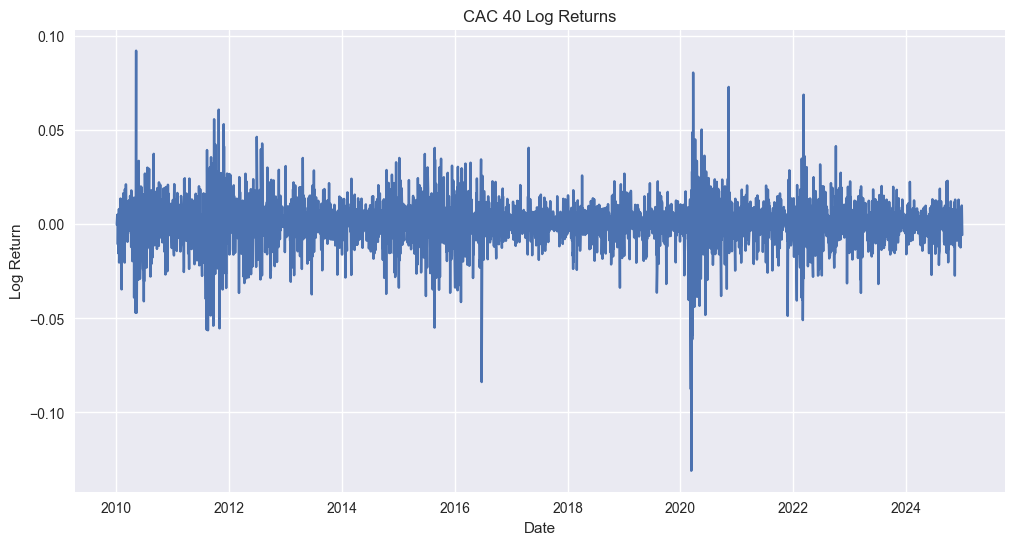

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data['log_return'])
plt.title("CAC 40 Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


In [12]:
mean_return = data['log_return'].mean()
volatility = data['log_return'].std()

print("Mean daily return:", mean_return)
print("Daily volatility:", volatility)


Mean daily return: 0.00015648132449748743
Daily volatility: 0.0124422751715149


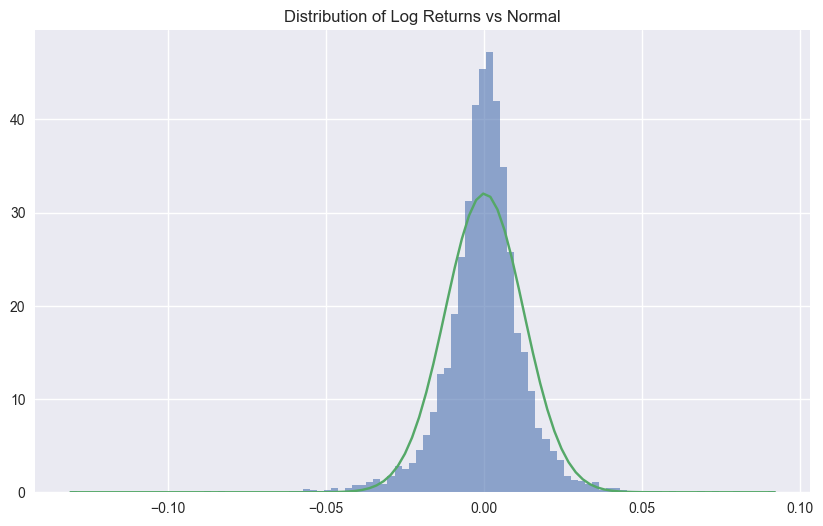

In [13]:
plt.figure(figsize=(10,6))
plt.hist(data['log_return'], bins=100, density=True, alpha=0.6)

# Overlay normal distribution
x = np.linspace(data['log_return'].min(), data['log_return'].max(), 100)
plt.plot(x, norm.pdf(x, mean_return, volatility))

plt.title("Distribution of Log Returns vs Normal")
plt.show()


In [14]:
from scipy.stats import skew, kurtosis

skewness = skew(data['log_return'])
kurt = kurtosis(data['log_return'])

print("Skewness:", skewness)
print("Excess Kurtosis:", kurt)


Skewness: -0.49063991295080406
Excess Kurtosis: 7.996490290297535


In [15]:
confidence_level = 0.05  # 95% VaR

mu = data['log_return'].mean()
sigma = data['log_return'].std()

z = norm.ppf(confidence_level)

var_parametric = mu + z * sigma

print("Parametric VaR (95%):", var_parametric)


Parametric VaR (95%): -0.020309240118897055


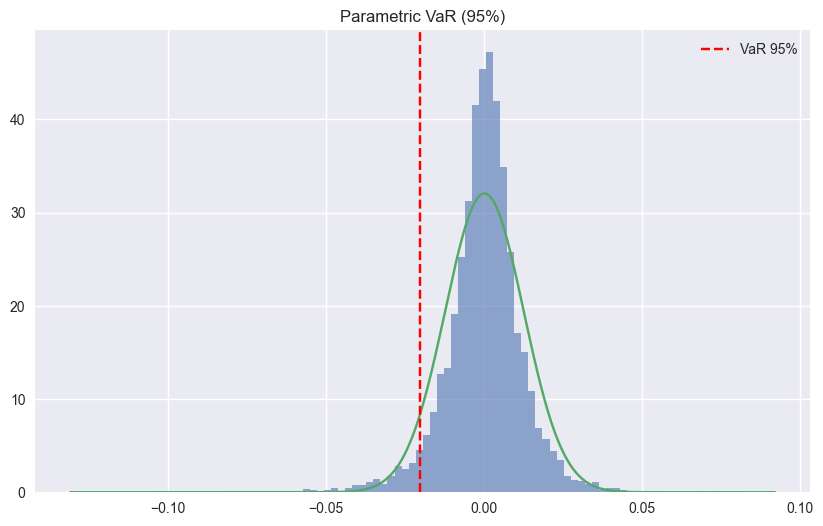

In [16]:
plt.figure(figsize=(10,6))

plt.hist(data['log_return'], bins=100, density=True, alpha=0.6)

x = np.linspace(data['log_return'].min(), data['log_return'].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma))

plt.axvline(var_parametric, color='red', linestyle='--', label='VaR 95%')

plt.title("Parametric VaR (95%)")
plt.legend()
plt.show()


In [17]:
var_historical = np.percentile(data['log_return'], 5)

print("Historical VaR (95%):", var_historical)


Historical VaR (95%): -0.0192786548930179


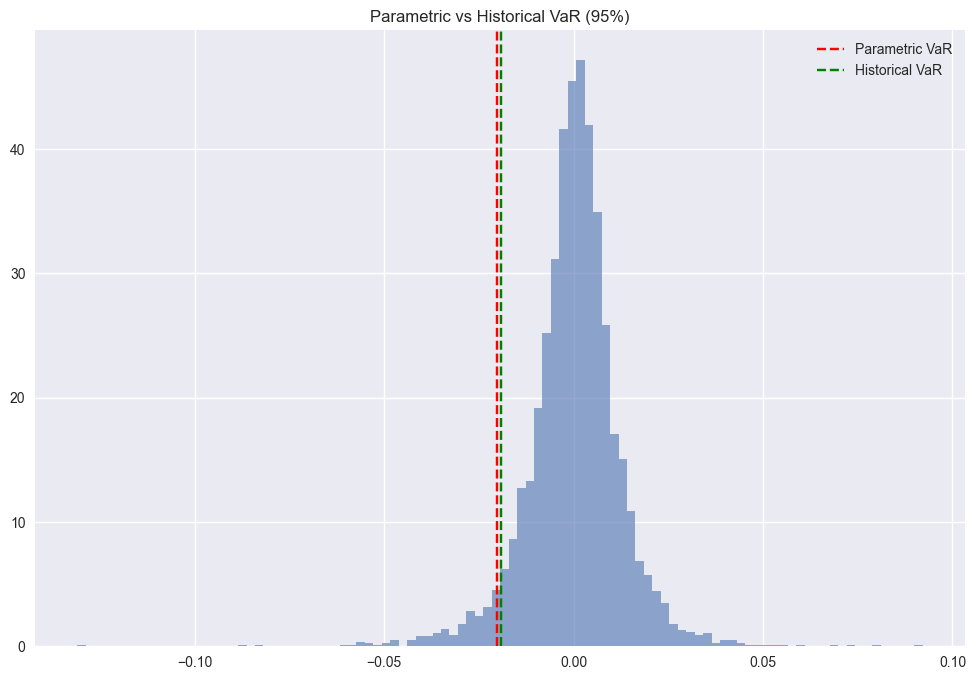

In [18]:
plt.figure(figsize=(12,8))

plt.hist(data['log_return'], bins=100, density=True, alpha=0.6)

plt.axvline(var_parametric, color='red', linestyle='--', label='Parametric VaR')
plt.axvline(var_historical, color='green', linestyle='--', label='Historical VaR')

plt.title("Parametric vs Historical VaR (95%)")
plt.legend()
plt.show()


In [19]:
confidence_level_99 = 0.01

z_99 = norm.ppf(confidence_level_99)

var_parametric_99 = mu + z_99 * sigma
var_historical_99 = np.percentile(data['log_return'], 1)

print("Parametric VaR (99%):", var_parametric_99)
print("Historical VaR (99%):", var_historical_99)


Parametric VaR (99%): -0.02878857906898734
Historical VaR (99%): -0.03655047419217682


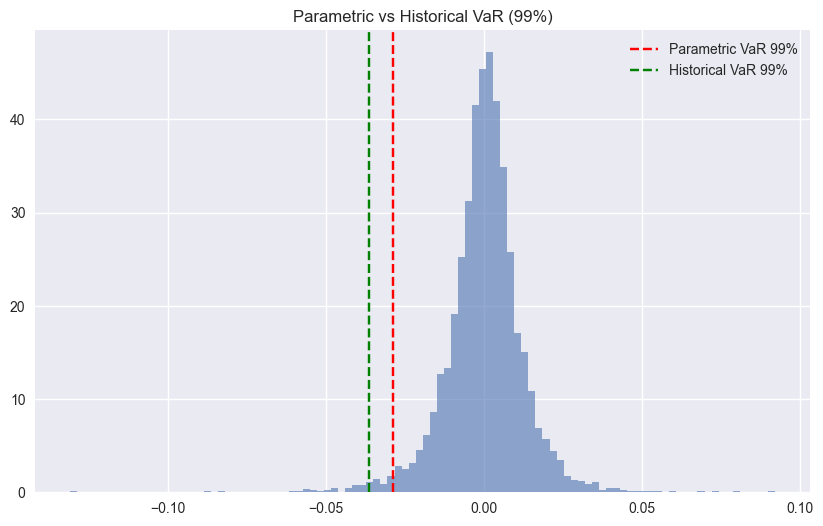

In [20]:
plt.figure(figsize=(10,6))

plt.hist(data['log_return'], bins=100, density=True, alpha=0.6)

plt.axvline(var_parametric_99, color = "red", linestyle='--', label='Parametric VaR 99%')
plt.axvline(var_historical_99, color = "green", linestyle='--', label='Historical VaR 99%')

plt.title("Parametric vs Historical VaR (99%)")
plt.legend()
plt.show()


In [21]:
# Expected Shortfall (Historical) 99%

var_threshold = var_historical_99

es_historical_99 = data['log_return'][data['log_return'] <= var_threshold].mean()

print("Historical Expected Shortfall (99%):", es_historical_99)


Historical Expected Shortfall (99%): -0.048980000101537816


In [22]:
alpha = 0.01

z = norm.ppf(alpha)

es_parametric_99 = mu - sigma * (norm.pdf(z) / alpha)

print("Parametric Expected Shortfall (99%):", es_parametric_99)


Parametric Expected Shortfall (99%): -0.033004847396079603


In [23]:
window = 250
alpha = 0.01

rolling_var = []

returns = data['log_return']

for i in range(window, len(returns)):
    
    sample = returns[i-window:i]
    
    mu_roll = sample.mean()
    sigma_roll = sample.std()
    
    z = norm.ppf(alpha)
    
    var_roll = mu_roll + z * sigma_roll
    
    rolling_var.append(var_roll)

# Convert to Series
rolling_var = pd.Series(rolling_var, index=returns.index[window:])


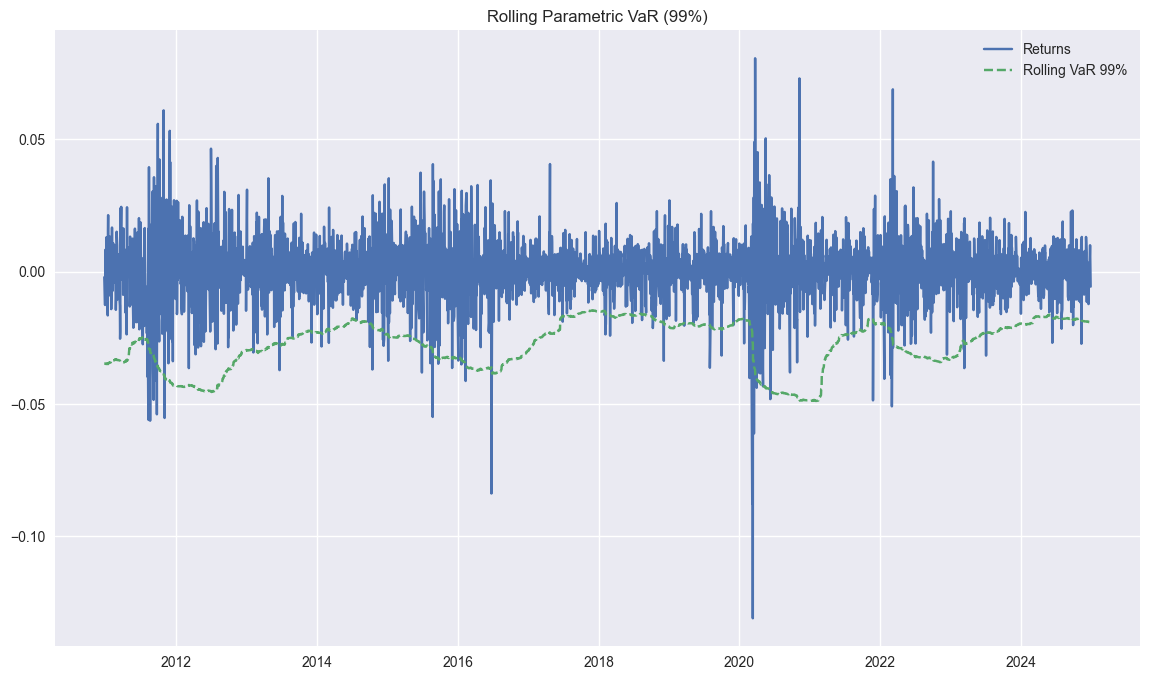

In [24]:
plt.figure(figsize=(14,8))

plt.plot(returns.index[window:], returns[window:], label="Returns")
plt.plot(rolling_var.index, rolling_var, label="Rolling VaR 99%", linestyle='--')

plt.title("Rolling Parametric VaR (99%)")
plt.legend()
plt.show()


In [25]:
violations = returns[window:] < rolling_var

n_violations = violations.sum()
total_obs = len(violations)

violation_ratio = n_violations / total_obs

print("Number of violations:", n_violations)
print("Total observations:", total_obs)
print("Violation ratio:", violation_ratio)


Number of violations: 80
Total observations: 3584
Violation ratio: 0.022321428571428572


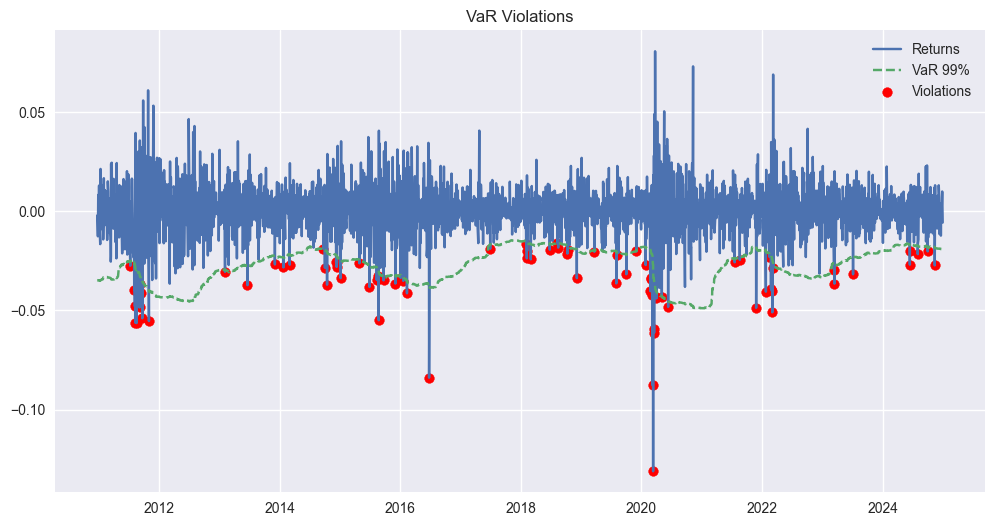

In [26]:
plt.figure(figsize=(12,6))

plt.plot(returns.index[window:], returns[window:], label="Returns")
plt.plot(rolling_var.index, rolling_var, linestyle='--', label="VaR 99%")

plt.scatter(returns.index[window:][violations],
            returns[window:][violations],
            color='red',
            label='Violations')

plt.title("VaR Violations")
plt.legend()
plt.show()


In [27]:
import numpy as np
from scipy.stats import chi2

alpha = 0.01
N = total_obs
x = n_violations

# Likelihood under null
LR = -2 * (
    ( (N - x) * np.log(1 - alpha) + x * np.log(alpha) ) -
    ( (N - x) * np.log(1 - x/N) + x * np.log(x/N) )
)

p_value = 1 - chi2.cdf(LR, df=1)

print("Kupiec Test Statistic:", LR)
print("p-value:", p_value)


Kupiec Test Statistic: 40.7058322660007
p-value: 1.7695822585039878e-10


In [28]:
from arch import arch_model

# Multiply returns by 100 (important for numerical stability)
returns_pct = returns * 100

garch = arch_model(returns_pct, vol='Garch', p=1, q=1, dist='normal')

garch_fit = garch.fit(disp='off')

print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5740.71
Distribution:                  Normal   AIC:                           11489.4
Method:            Maximum Likelihood   BIC:                           11514.4
                                        No. Observations:                 3834
Date:                Mon, Feb 16 2026   Df Residuals:                     3833
Time:                        17:12:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0565  1.632e-02      3.460  5.394e-04 [2.

In [29]:
conditional_vol = garch_fit.conditional_volatility

# Convert back to decimal
conditional_vol = conditional_vol / 100


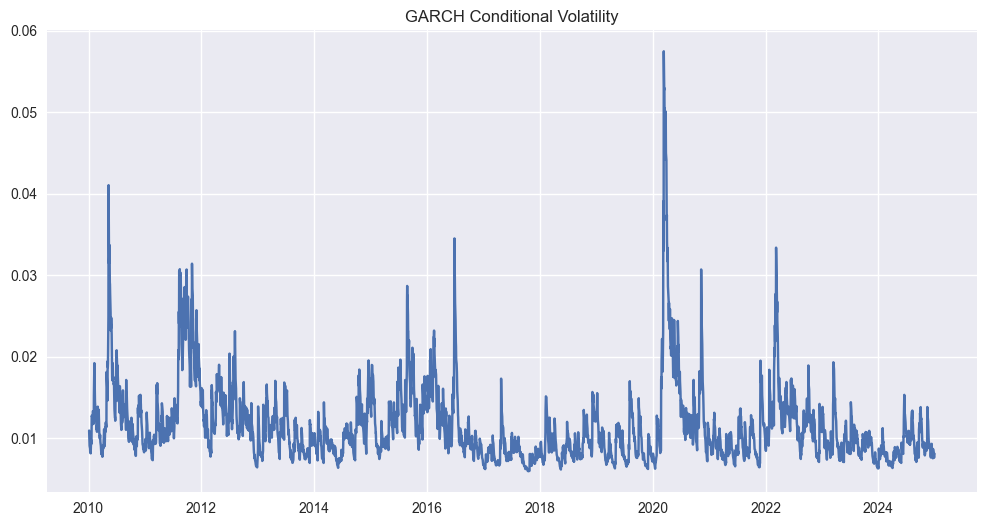

In [30]:
plt.figure(figsize=(12,6))
plt.plot(conditional_vol)
plt.title("GARCH Conditional Volatility")
plt.show()


In [31]:
alpha = 0.01
z = norm.ppf(alpha)

mu_garch = returns.mean()

var_garch = mu_garch + z * conditional_vol

var_garch = pd.Series(var_garch, index=returns.index)


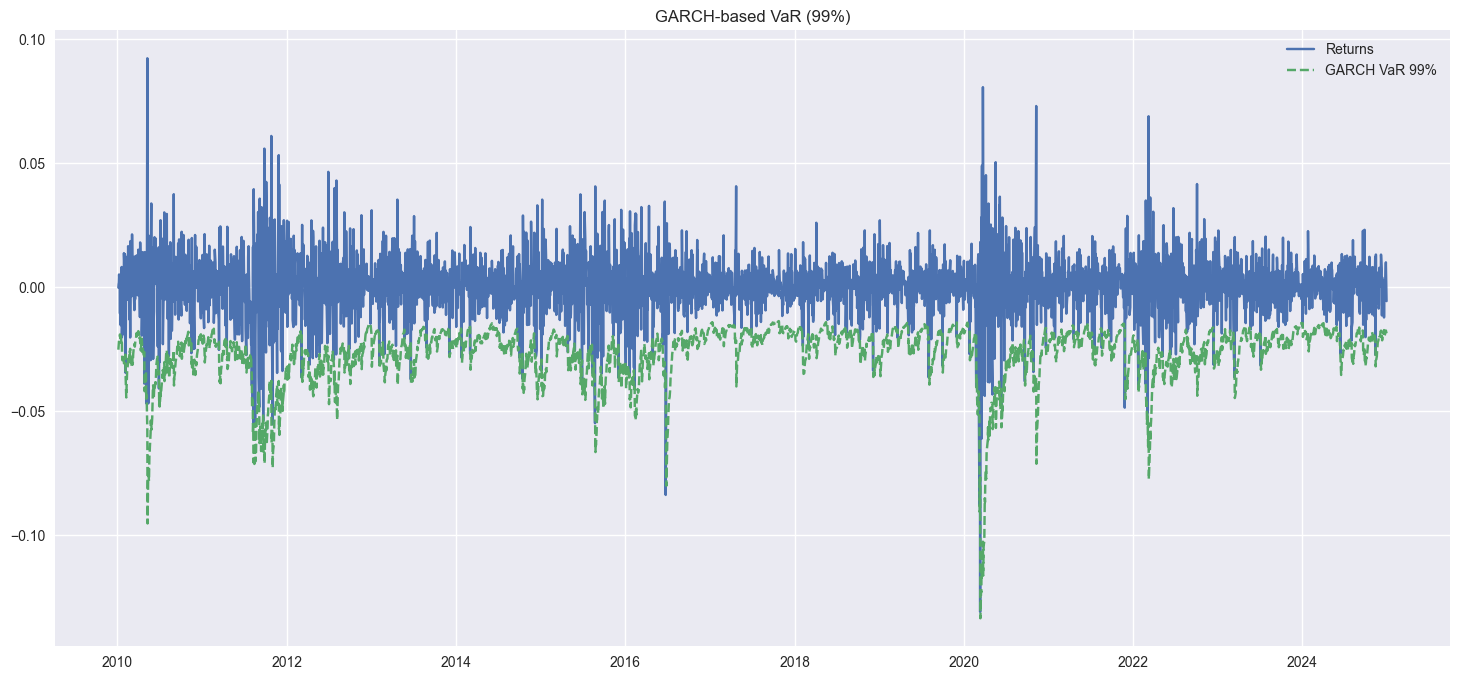

In [34]:
plt.figure(figsize=(18,8))

plt.plot(returns, label="Returns")
plt.plot(var_garch, linestyle='--', label="GARCH VaR 99%")

plt.title("GARCH-based VaR (99%)")
plt.legend()
plt.show()


In [35]:
violations_garch = returns < var_garch

n_violations_garch = violations_garch.sum()
total_obs_garch = len(violations_garch)

ratio_garch = n_violations_garch / total_obs_garch

print("Number of violations (GARCH):", n_violations_garch)
print("Violation ratio (GARCH):", ratio_garch)


Number of violations (GARCH): 75
Violation ratio (GARCH): 0.019561815336463225


In [36]:
N = total_obs_garch
x = n_violations_garch
alpha = 0.01

LR_garch = -2 * (
    ((N - x) * np.log(1 - alpha) + x * np.log(alpha)) -
    ((N - x) * np.log(1 - x/N) + x * np.log(x/N))
)

p_value_garch = 1 - chi2.cdf(LR_garch, df=1)

print("Kupiec Test Statistic (GARCH):", LR_garch)
print("p-value (GARCH):", p_value_garch)


Kupiec Test Statistic (GARCH): 27.684378783112038
p-value (GARCH): 1.4281130078508397e-07
